In [1]:
from datatree import DataTree
import xarray as xr 
import pandas as pd 
import fsspec 
import dask 
from distributed import Client


In [2]:
cat_df =  pd.read_csv('s3://carbonplan-share/nasa-nex-reference/reference_catalog_prod.csv') 

In [3]:
catalog = cat_df.set_index('ID').T.to_dict('records')[0]

In [39]:
def load_ref_ds(url: str):

    fs = fsspec.filesystem(
        "reference",
        fo=url,
        remote_protocol="s3",
        remote_options={"anon": True},
        skip_instance_cache=True,
    
    )
    m = fs.get_mapper("")
    return xr.open_dataset(m, engine="zarr", consolidated=False, chunks={})


tasks = {id: dask.delayed(load_ref_ds)(url) for id, url in catalog.items()}


In [22]:
client = Client(n_workers=8)
client

/Users/nrhagen/micromamba/envs/nasa-nex/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50344 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50344/status,
Dashboard: http://127.0.0.1:50344/status,Workers: 8
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50345,Workers: 8
Dashboard: http://127.0.0.1:50344/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:50370,Total threads: 1
Dashboard: http://127.0.0.1:50373/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:50348,


In [40]:
catalog_computed = dask.compute(tasks)

In [46]:
dt = DataTree.from_dict(catalog_computed[0])

In [49]:
print(f"Size of data in tree = {dt.nbytes / 1e12 :.2f} TB")

Size of data in tree = 146.34 TB


In [23]:
dt['ACCESS-CM2_historical']

DataTree('ACCESS-CM2_historical', parent="None")
    Dimensions:  (time: 23741, lat: 600, lon: 1440)
    Coordinates:
      * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
      * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
      * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 2014-12-31T12:00:00
    Data variables:
        hurs     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
        huss     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
        pr       (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
        rlds     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
        rsds     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
        sfcWind  (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
        tas      (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
        tasmax   (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
        tasmin   (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    Attributes: (12/22)
        Conventions:           CF-1.7
        activity:              NEX-GDDP-CMIP6
        cmip6_institution_id:  CSIRO-ARCCSS
        cmip6_license:         CC-BY-SA 4.0
        cmip6_source_id:       ACCESS-CM2
        contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
        ...                    ...
        scenario:              historical
        source:                BCSD
        title:                 ACCESS-CM2, r1i1p1f1, historical, global downscale...
        tracking_id:           16d27564-470f-41ea-8077-f4cc3efa5bfe
        variant_label:         r1i1p1f1
        version:               1.0

In [24]:
timeseries = dt['ACCESS-CM2_historical'].mean(dim=["lat", "lon"])

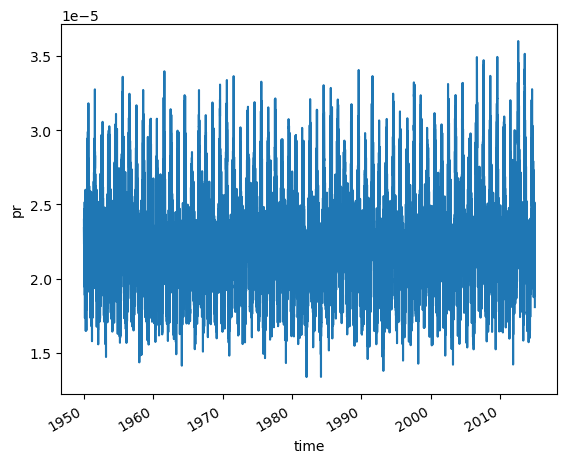

In [28]:
timeseries.pr.plot()